In [1]:
import os

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from enum import Enum, EnumMeta
from typing import Set, Literal

from mdp.trauma_icu_resuscitation.state_spaces import discrete as state_space
from mdp.trauma_icu_resuscitation.action_spaces import discrete as action_space
from utilities import trauma_icu_resuscitation_funcs

/Users/larry/anaconda3/envs/ope_310_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('..')

In [3]:
base_dir = '<path_to_repo>/datasets/trauma_icu_resuscitation/preprocessed_cohort'
p_ids = {int(f.name.split('_')[-1][:-3]) for f in os.scandir(base_dir) if f.is_file() and not f.name.startswith('.')} # filter out .DS_Store
len(p_ids)

4305

In [4]:
def plot_patient_trajectory_actions_dones(p_id: int, base_dir_: str):
    actions = torch.load(f'{base_dir_}/discrete_actions_{p_id}.pt')
    dones = torch.load(f'{base_dir_}/dones_{p_id}.pt')
    rewards = torch.load(f'{base_dir_}/sparse_rewards_{p_id}.pt')
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))
    sns.lineplot(data={'ivf': actions.squeeze()[:, 0].numpy(), 'norepinephrine': actions.squeeze()[:, 1].numpy(), 'vasopressin': actions.squeeze()[:, 2].numpy()}, ax=axes[0])
    axes[0].set_title('Actions')
    sns.lineplot(data={'dones': dones.squeeze().numpy()}, ax=axes[1])
    axes[1].set_title('Dones')
    sns.lineplot(data={'rewards': rewards.squeeze().numpy()}, ax=axes[2])
    axes[2].set_title('Rewards')
    fig.tight_layout()
    plt.show()

In [6]:
def plot_patient_trajectory_states(p_id_: int, base_dir_: str):
    states = torch.load(f'{base_dir_}/states_{p_id_}.pt')
    fig, axes = plt.subplots(2, 1, figsize=(10, 20))
    data_dict0, data_dict1 = dict(), dict()
    for i, component in enumerate(state_space.Components):
        if component in {state_space.Components.HR, state_space.Components.MAP, state_space.Components.DBP, state_space.Components.SBP}:
            data_dict, ax = data_dict0, axes[0]
        else:
            data_dict, ax = data_dict1, axes[1]
        data_dict[component.name] = states.squeeze()[:, i].numpy()
    sns.lineplot(data=data_dict0, ax=axes[0])
    axes[0].set_title('Continuous State Components')
    sns.lineplot(data=data_dict1, ax=axes[1])
    axes[1].set_title('Discrete State Components')
    fig.tight_layout()
    plt.show()

# Find Longest Trajectory

In [5]:
from typing import Tuple

def find_longest_trajectory(p_ids_: Set[int], base_dir_: str) -> Tuple[int, int]:
    max_len = 0
    max_p_id = None
    for p_id in p_ids_:
        dones = torch.load(f'{base_dir_}/dones_{p_id}.pt')
        missing = torch.load(f'{base_dir_}/missing_{p_id}.pt')
        dones = dones[~missing]
        if dones.size(0) > max_len:
            max_len = dones.size(0)
            max_p_id = p_id
    return max_p_id, max_len

def compute_trajectory_length_stats(p_ids_: Set[int], base_dir_: str):
    lengths = []
    for p_id in p_ids_:
        dones = torch.load(f'{base_dir_}/dones_{p_id}.pt')
        missing = torch.load(f'{base_dir_}/missing_{p_id}.pt')
        dones = dones[~missing]
        lengths.append(dones.size(0))
    lengths = np.array(lengths)
    return lengths.mean(), lengths.std(), lengths.min(), lengths.max(), np.quantile(lengths, 0.25), np.quantile(lengths, 0.75)

def outlier_trajectory_lengths(p_ids_: Set[int], base_dir_: str, threshold: int = 500):
    lengths = []
    for p_id in p_ids_:
        dones = torch.load(f'{base_dir_}/dones_{p_id}.pt')
        missing = torch.load(f'{base_dir_}/missing_{p_id}.pt')
        dones = dones[~missing]
        #if dones.size(1) > threshold:
        lengths.append(dones.size(0))
    lengths = np.array(lengths)
    q1, q3 = np.quantile(lengths, 0.25), np.quantile(lengths, 0.75)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return lengths[lengths < lower_bound], lengths[lengths > upper_bound]

def trajectories_w_zero_length(p_ids_: Set[int], base_dir_: str):
    zero_lengths = []
    for p_id in p_ids_:
        dones = torch.load(f'{base_dir_}/dones_{p_id}.pt')
        missing = torch.load(f'{base_dir_}/missing_{p_id}.pt')
        dones = dones[~missing]
        if dones.size(0) == 0:
            zero_lengths.append(p_id)
    return zero_lengths

In [6]:
find_longest_trajectory(p_ids, base_dir)

(4002, 72)

In [7]:
mean_, std_, min_, max_, q1_, q3_ = compute_trajectory_length_stats(p_ids, base_dir)
print(f'Mean: {mean_}, Std: {std_}, Min: {min_}, Max: {max_}, Q1: {q1_}, Q3: {q3_}')

Mean: 29.200232288037167, Std: 20.597798782790665, Min: 2, Max: 72, Q1: 8.0, Q3: 51.0


In [8]:
outlier_trajectory_lengths(p_ids, base_dir)

(array([], dtype=int64), array([], dtype=int64))

In [9]:
trajectories_w_zero_length(p_ids, base_dir)

[]

In [10]:
def plot_state_distribution(num_splits: int, dset_plot: Literal['train', 'validation']):
    # MAP, DBP, SBP, HR get a histogram
    train_discrete_comps = np.empty((len(state_space.Components), 7), dtype=np.float32)
    val_discrete_comps = np.empty((len(state_space.Components), 7), dtype=np.float32)
    train_cont_comps = val_cont_comps = None
    cont_comps_indices = [state_space.Components.MAP.value, state_space.Components.DBP.value,
                          state_space.Components.SBP.value, state_space.Components.HR.value]
    for split in range(num_splits):
        (
            (train_states, train_actions, train_rewards, train_dones, train_next_states, _),
            (val_states, val_actions, val_rewards, val_dones, val_next_states, _),
            (_, _, _, _, _, _)
        ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'iql', 'discrete')
        for component_idx in range(state_space.Components.n_components()):
            if component_idx not in cont_comps_indices:
                uniques, cts = np.unique(train_states[:, component_idx].numpy(), return_counts=True)
                train_discrete_comps[component_idx, uniques] += cts
                uniques, cts = np.unique(val_states[:, component_idx].numpy(), return_counts=True)
                val_discrete_comps[component_idx, uniques] += cts
        cur_train_cont_comp_slice = train_states[:, cont_comps_indices]
        cur_val_cont_comp_slice = val_states[:, cont_comps_indices]
        if train_cont_comps is None:
            train_cont_comps = cur_train_cont_comp_slice
            val_cont_comps = cur_val_cont_comp_slice
        else:
            train_cont_comps = torch.concat([train_cont_comps, cur_train_cont_comp_slice], dim=0)
            val_cont_comps = torch.concat([val_cont_comps, cur_val_cont_comp_slice], dim=0)
    # normalize each set of discrete components by component
    for discrete_comps in (train_discrete_comps, val_discrete_comps):
        for component_idx in range(state_space.Components.n_components()):
            if discrete_comps[component_idx].sum() > 0:
                discrete_comps[component_idx] /= discrete_comps[component_idx].sum()
    # create discrete component dataframes
    train_df = pd.DataFrame.from_dict({
        comp.name: train_discrete_comps[comp.value] for comp in state_space.Components
    })
    train_df.drop(columns=[comp.name for comp in {state_space.Components.HR, state_space.Components.MAP,
                                                  state_space.Components.SBP, state_space.Components.DBP}],
                  inplace=True)
    val_df = pd.DataFrame.from_dict({
        comp.name: val_discrete_comps[comp.value] for comp in state_space.Components
    })
    val_df.drop(columns=[comp.name for comp in {state_space.Components.HR, state_space.Components.MAP,
                                                state_space.Components.SBP, state_space.Components.DBP}],
                inplace=True)
    plot_df = train_df if dset_plot == 'train' else val_df
    # final touches on 'cont' components
    train_cont_df = pd.DataFrame.from_dict({
        state_space.Components.MAP.name: train_cont_comps[:, 0].numpy(),
        state_space.Components.DBP.name: train_cont_comps[:, 1].numpy(),
        state_space.Components.SBP.name: train_cont_comps[:, 2].numpy(),
        state_space.Components.HR.name: train_cont_comps[:, 3].numpy()
    })
    val_cont_df = pd.DataFrame.from_dict({
        state_space.Components.MAP.name: val_cont_comps[:, 0].numpy(),
        state_space.Components.DBP.name: val_cont_comps[:, 1].numpy(),
        state_space.Components.SBP.name: val_cont_comps[:, 2].numpy(),
        state_space.Components.HR.name: val_cont_comps[:, 3].numpy()
    })
    plot_cont_df = train_cont_df if dset_plot == 'train' else val_cont_df
    fig, axes = plt.subplots(2, 1, figsize=(30, 30))
    sns.heatmap(plot_df, ax=axes[0], cmap='Blues', annot=True)
    axes[0].invert_yaxis()
    sns.histplot(plot_cont_df, ax=axes[1], bins=100)

In [11]:
os.getcwd()

'/Users/larry/Documents/UWT/Thesis Work/rec_sys/repositories/off_policy_policy_evaluation'

Data Split: 100%|██████████| 3/3 [00:06<00:00,  2.31s/ split]


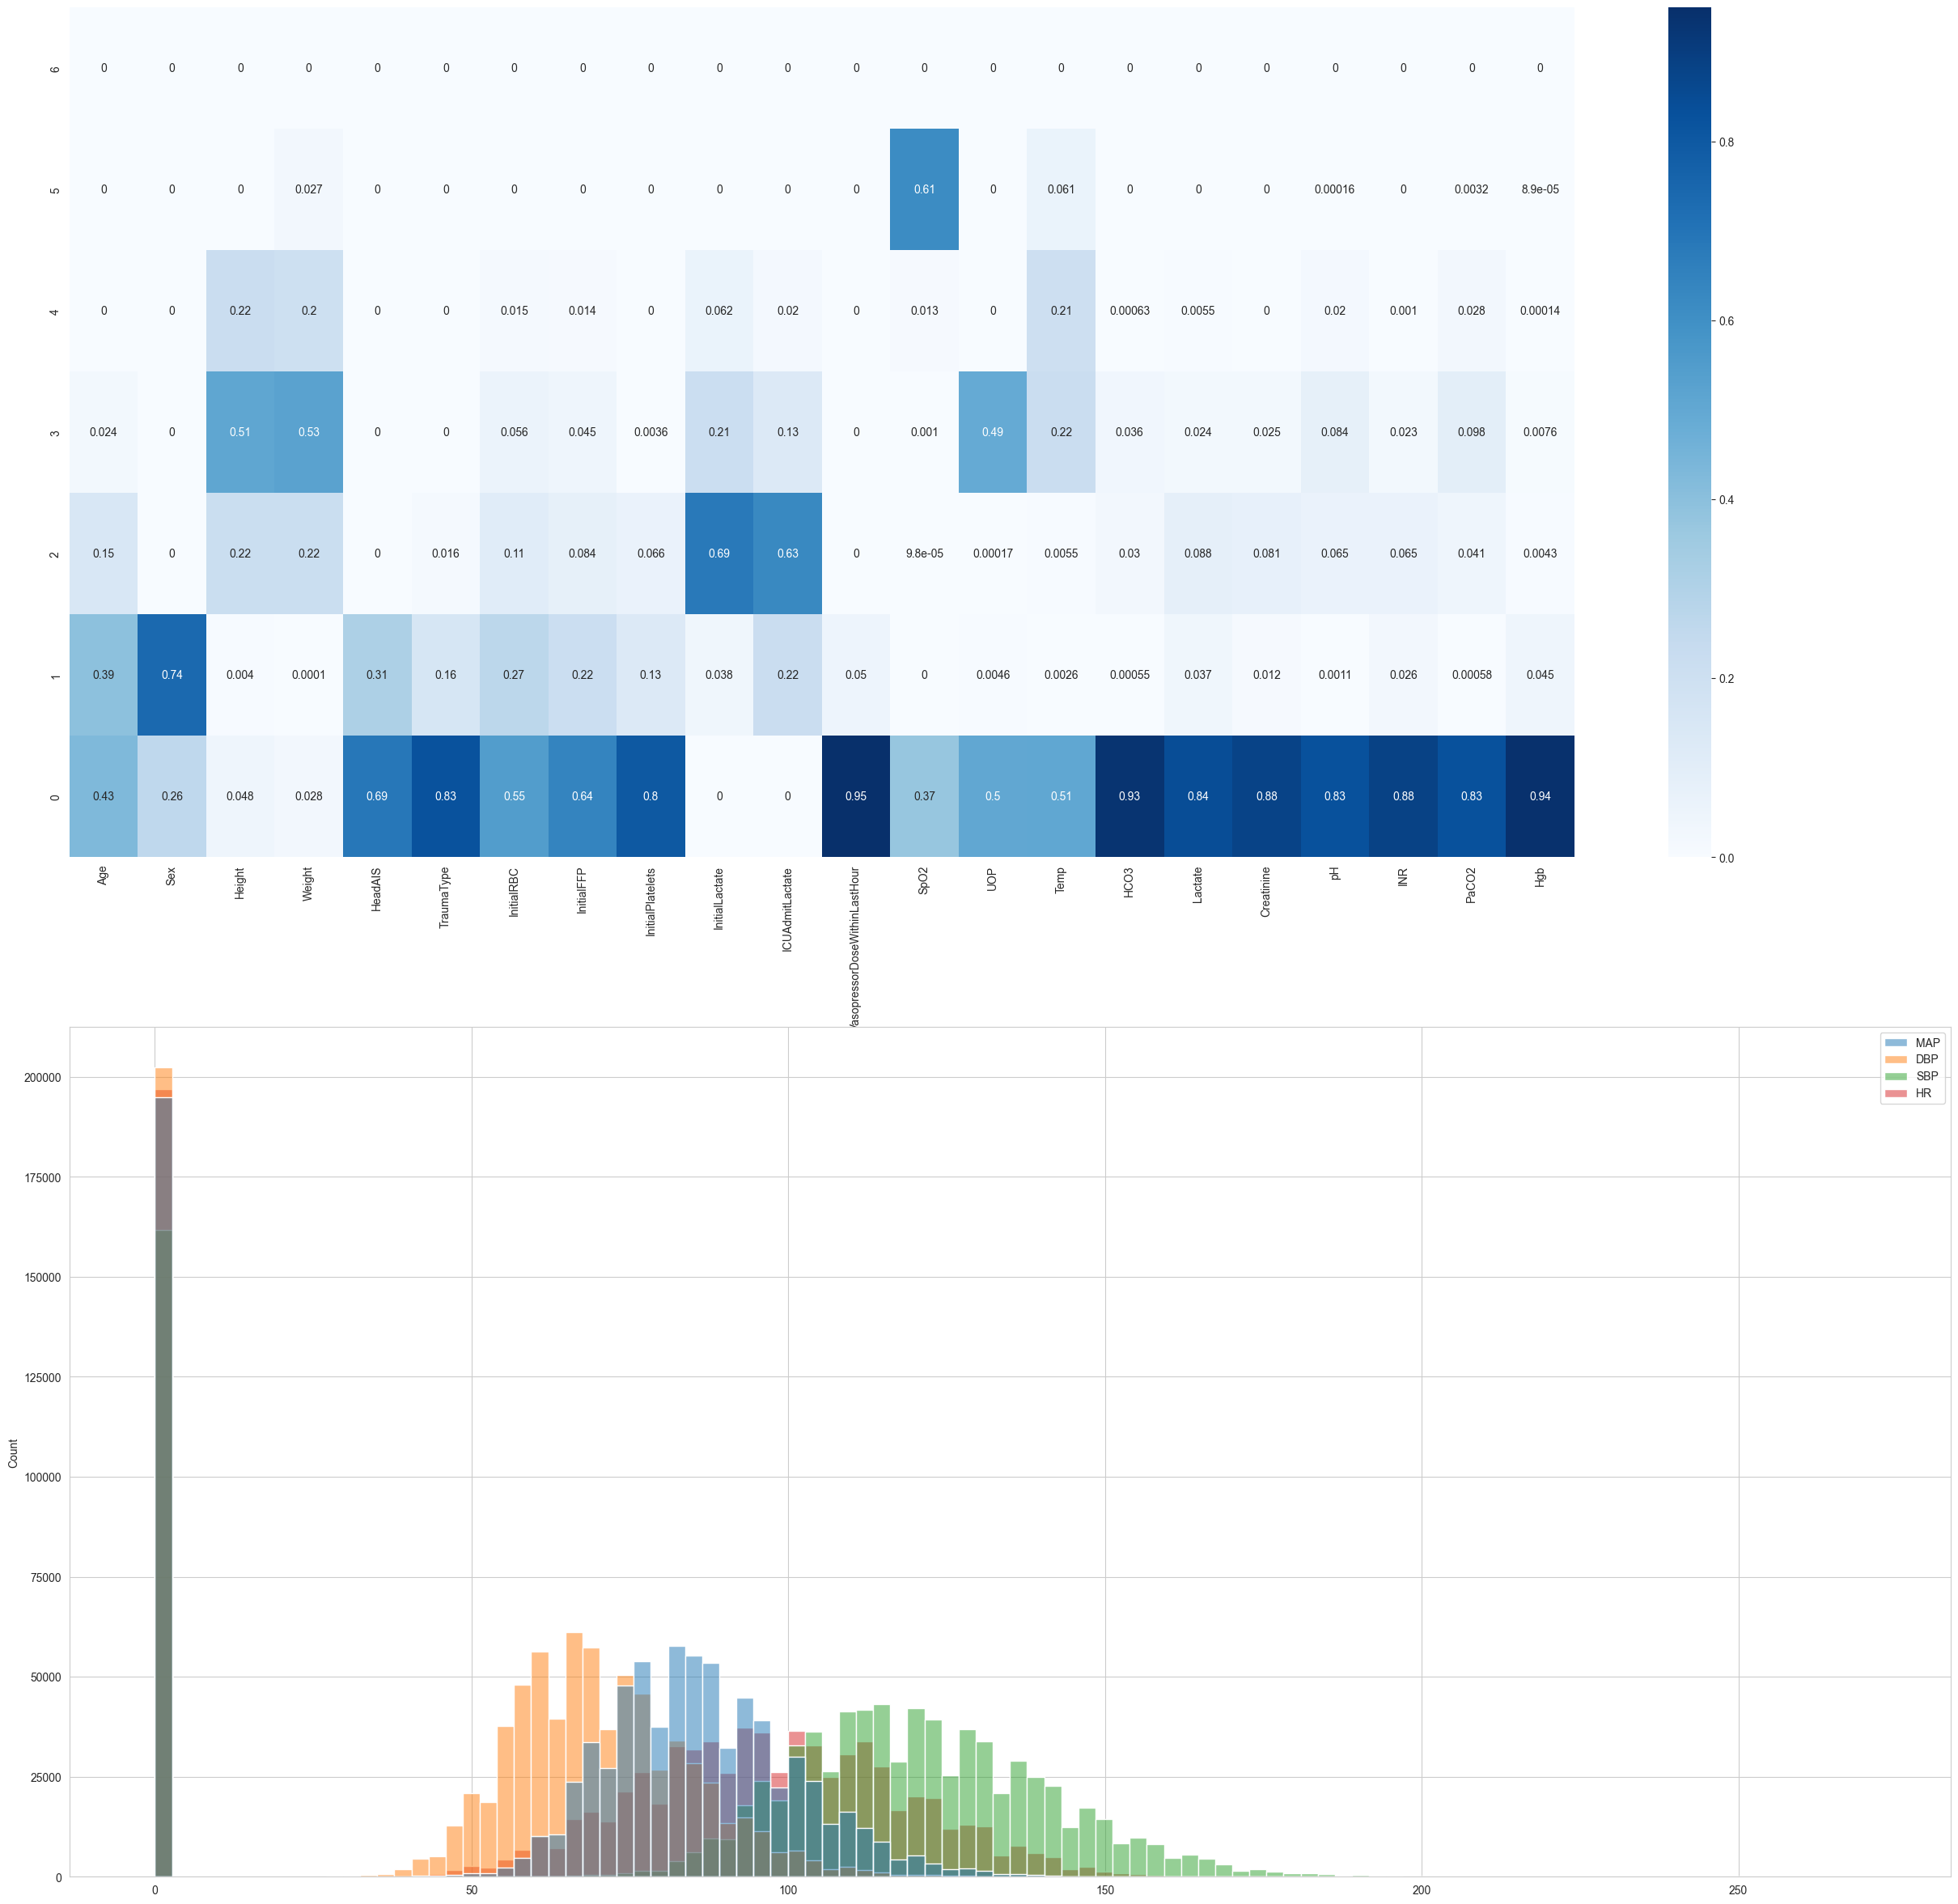

In [12]:
plot_state_distribution(10, 'train')

Data Split: 100%|██████████| 3/3 [00:06<00:00,  2.27s/ split]


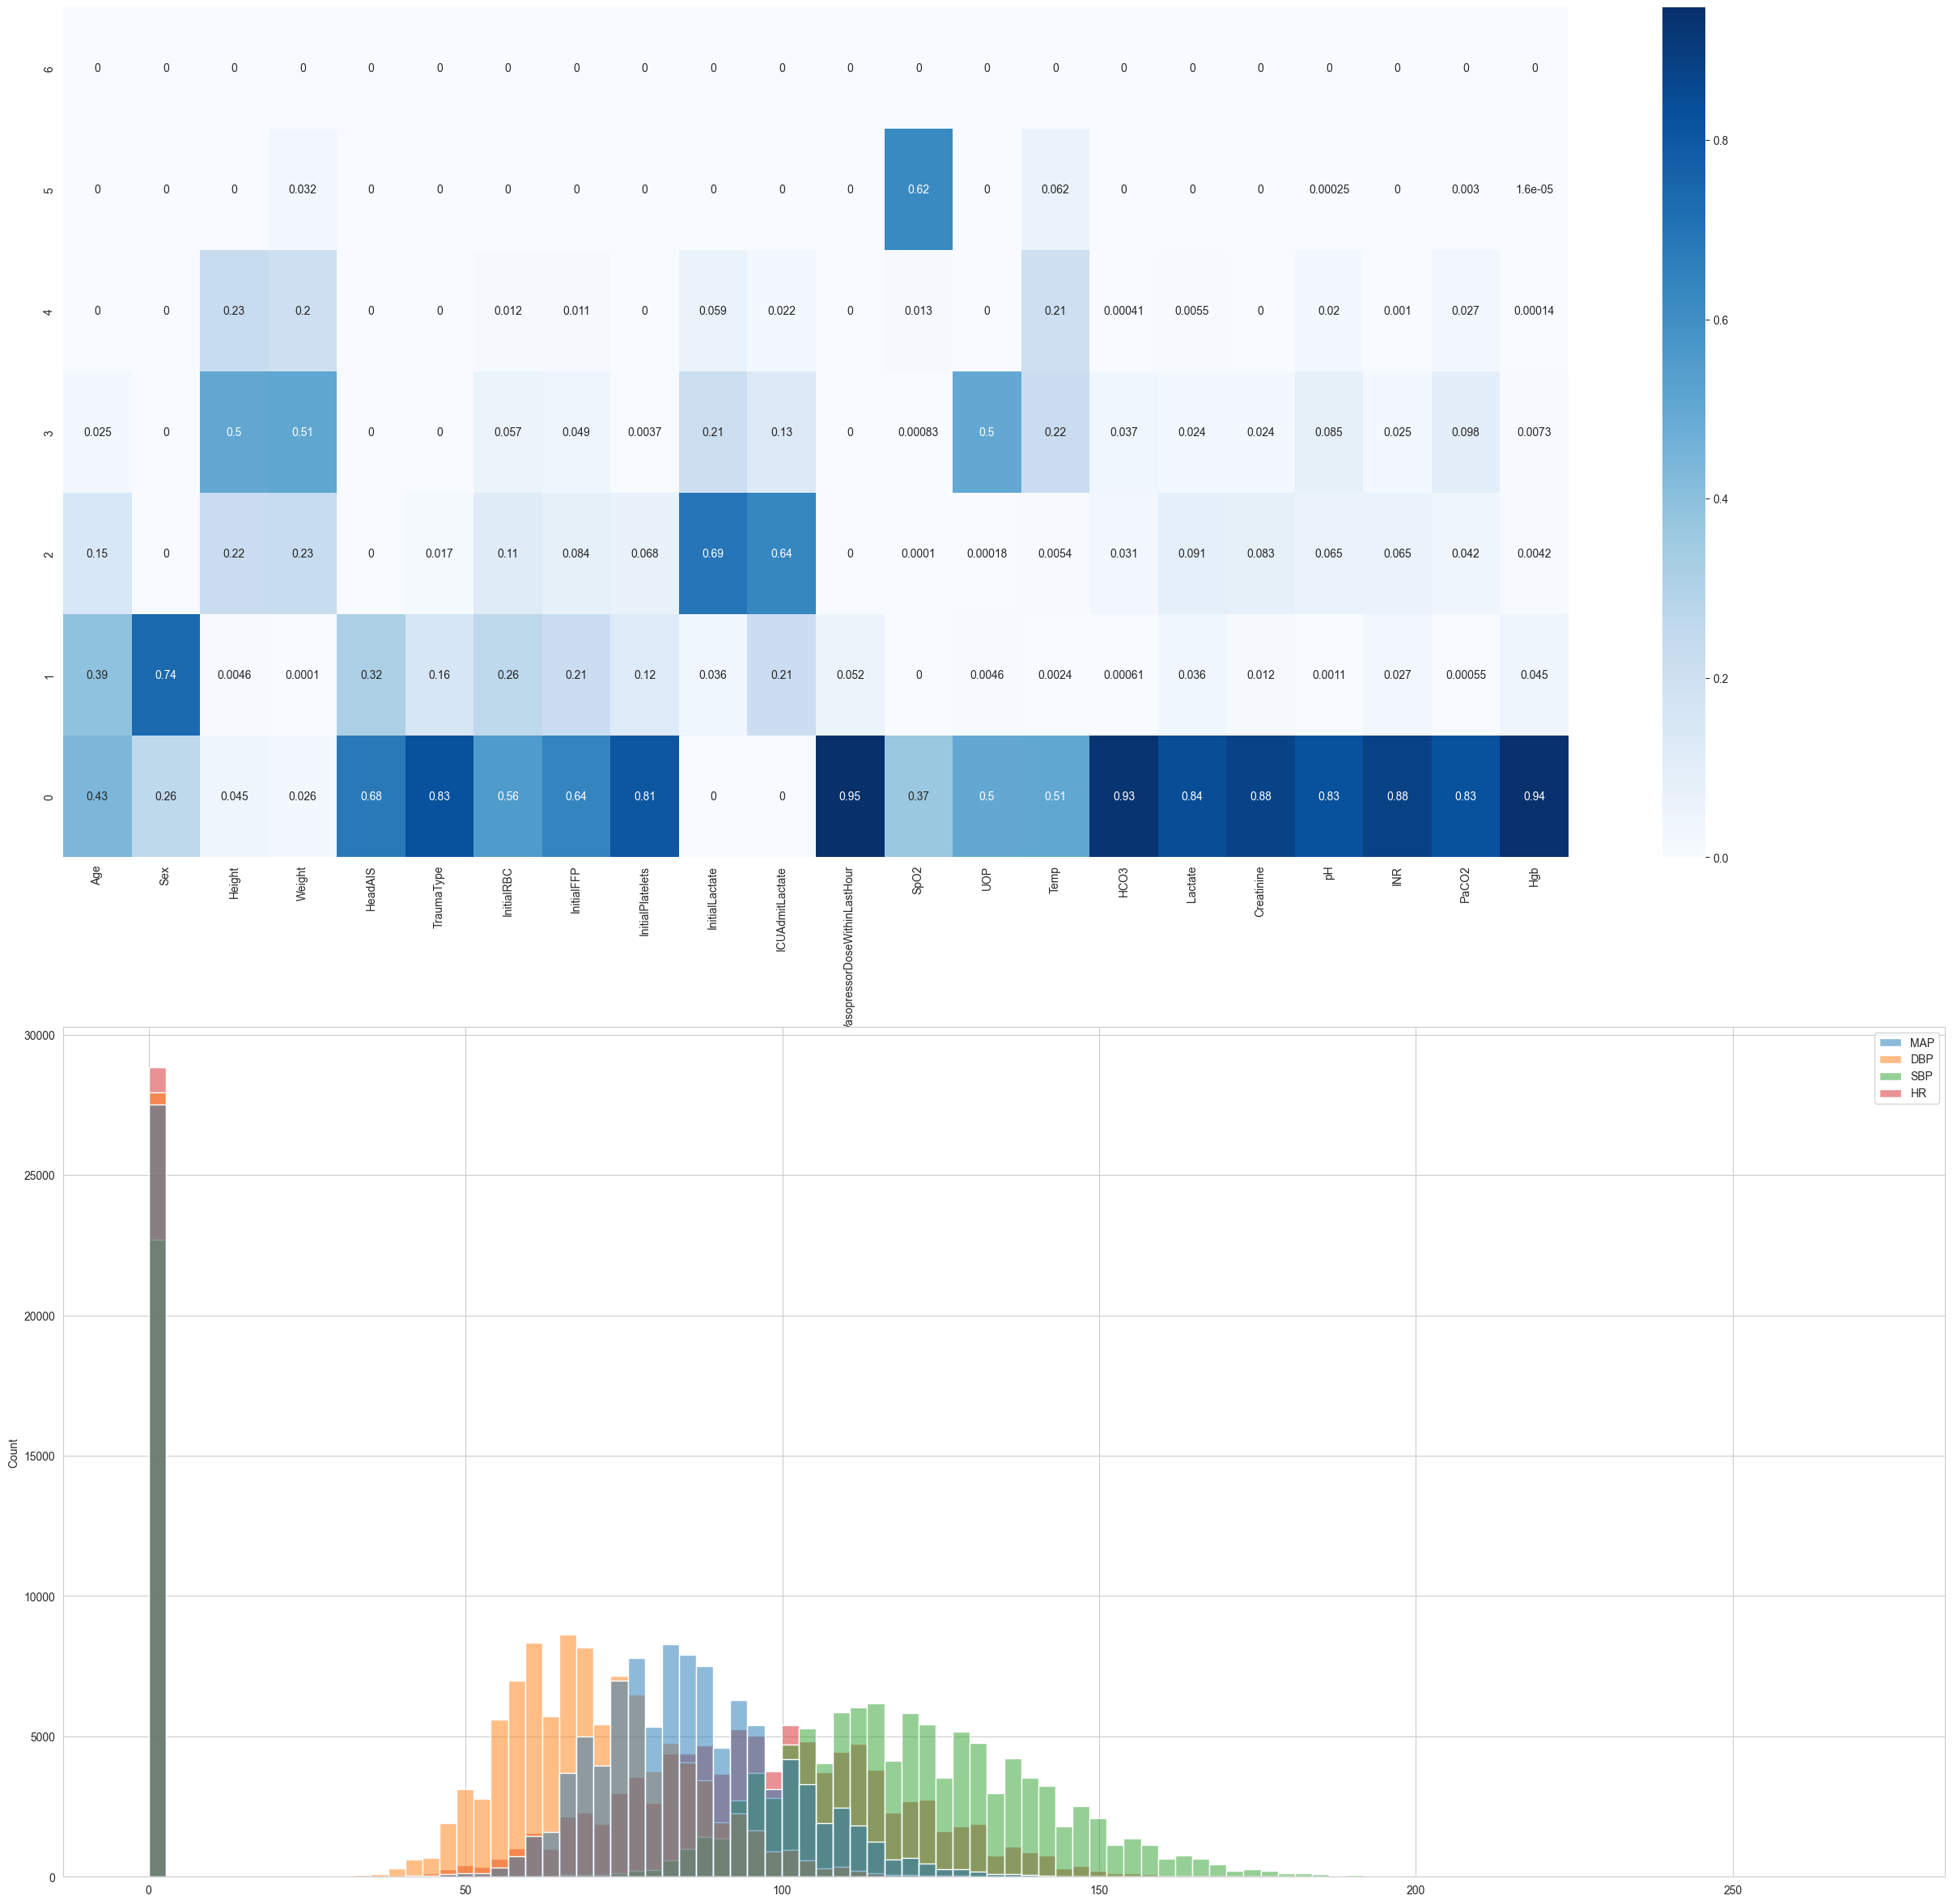

In [13]:
plot_state_distribution(10, 'validation')

In [14]:
def action_count(num_splits: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train_action_cts = np.zeros(12)
    train_sep_cts = np.zeros((3, 3))
    val_action_cts = np.zeros(12)
    val_sep_cts = np.zeros((3, 3))
    for split in range(num_splits):
        (
            (train_states, train_actions, train_rewards, train_dones, train_next_states, _),
            (val_states, val_actions, val_rewards, val_dones, val_next_states, _),
            (_, _, _, _, _, _)
        ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'iql', 'discrete')
        assert train_actions[:, 1].any(), 'no norepinephrine'
        for act_idx in range(3):
            uniques, cts = np.unique(train_actions.numpy()[:, act_idx], return_counts=True)
            train_sep_cts[act_idx, uniques] += cts
            uniques, cts = np.unique(val_actions.numpy()[:, act_idx], return_counts=True)
            val_sep_cts[act_idx, uniques] += cts
        # print(train_actions[:, 1].any())
        train_actions = trauma_icu_resuscitation_funcs.flatten_discrete_actions(train_actions).numpy()
        train_actions, cts = np.unique(train_actions, return_counts=True)
        train_action_cts[train_actions] += cts
        val_actions = trauma_icu_resuscitation_funcs.flatten_discrete_actions(val_actions)
        val_actions, cts = np.unique(val_actions, return_counts=True)
        val_action_cts[val_actions] += cts
    for act_idx in range(3):
        train_sep_cts[act_idx] /= train_sep_cts[act_idx].sum()
        val_sep_cts[act_idx] /= val_sep_cts[act_idx].sum()
    train_action_cts /= train_action_cts.sum()
    val_action_cts /= val_action_cts.sum()
    return train_action_cts, train_sep_cts, val_action_cts, val_sep_cts

In [15]:
train_action_counts, train_sep_counts, val_action_counts, val_sep_counts = action_count(10)

Data Split: 100%|██████████| 3/3 [00:27<00:00,  9.15s/ split]                     trans/s]]


In [16]:
train_action_counts

array([7.74245704e-01, 4.69700829e-03, 7.14750266e-02, 2.39478065e-02,
       3.35078272e-02, 6.27632189e-04, 4.00684028e-03, 2.37636101e-03,
       7.28724178e-02, 6.53783531e-04, 7.68735730e-03, 3.90223492e-03])

In [17]:
val_action_counts

array([7.68013040e-01, 5.88375606e-03, 7.13922239e-02, 2.62622247e-02,
       3.36487239e-02, 5.48620498e-04, 4.38896398e-03, 2.87031884e-03,
       7.47237020e-02, 1.06543691e-03, 7.85560945e-03, 3.34738014e-03])

In [18]:
# improves readability of [train|val]_action_counts
trauma_icu_resuscitation_funcs.unflatten_discrete_actions(torch.arange(12).unsqueeze(-1))

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1],
        [2, 0, 0],
        [2, 0, 1],
        [2, 1, 0],
        [2, 1, 1]])

In [19]:
train_sep_counts

array([[0.87436555, 0.04051866, 0.08511579],
       [0.88660437, 0.11339563, 0.        ],
       [0.96379517, 0.03620483, 0.        ]])

In [20]:
val_sep_counts

array([[0.87155124, 0.04145663, 0.08699213],
       [0.88388328, 0.11611672, 0.        ],
       [0.96002226, 0.03997774, 0.        ]])

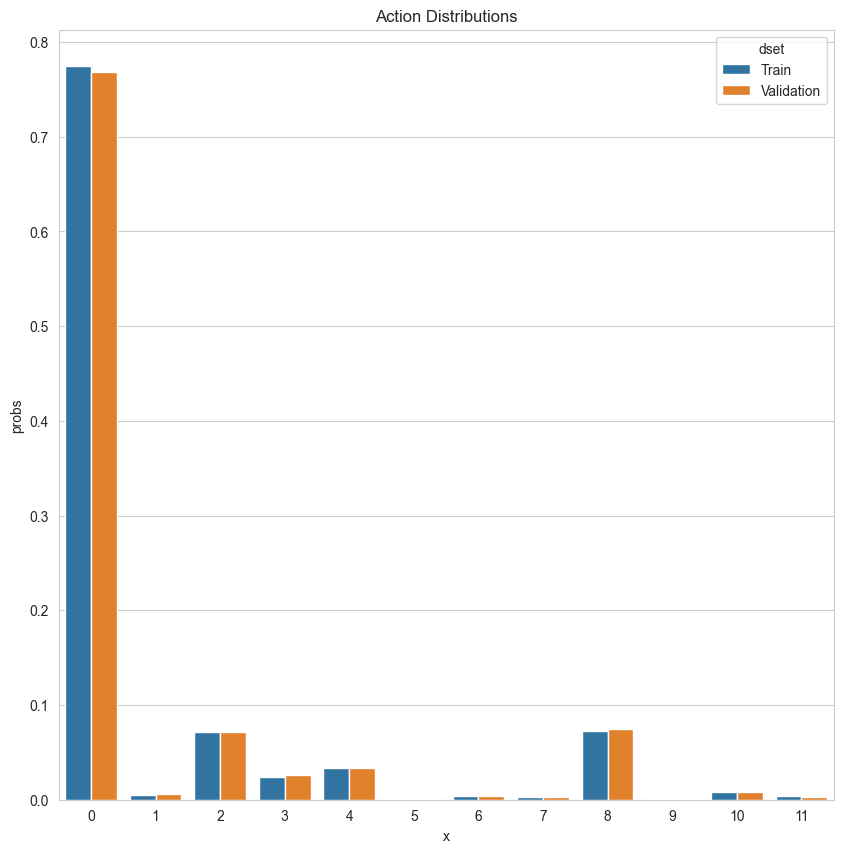

In [21]:
plt.figure(figsize=(10, 10))
action_df = pd.DataFrame.from_dict({
    'x': np.tile(np.arange(12), 2),
    'probs': np.concatenate([train_action_counts, val_action_counts]),
    'dset': np.repeat(['Train', 'Validation'], 12)
})
# ax = sns.lineplot({
#     'Train': train_action_counts,
#     'Val': val_action_counts
# })
ax = sns.barplot(data=action_df, x='x', y='probs', hue='dset')
ax.set_title('Action Distributions')
plt.show()

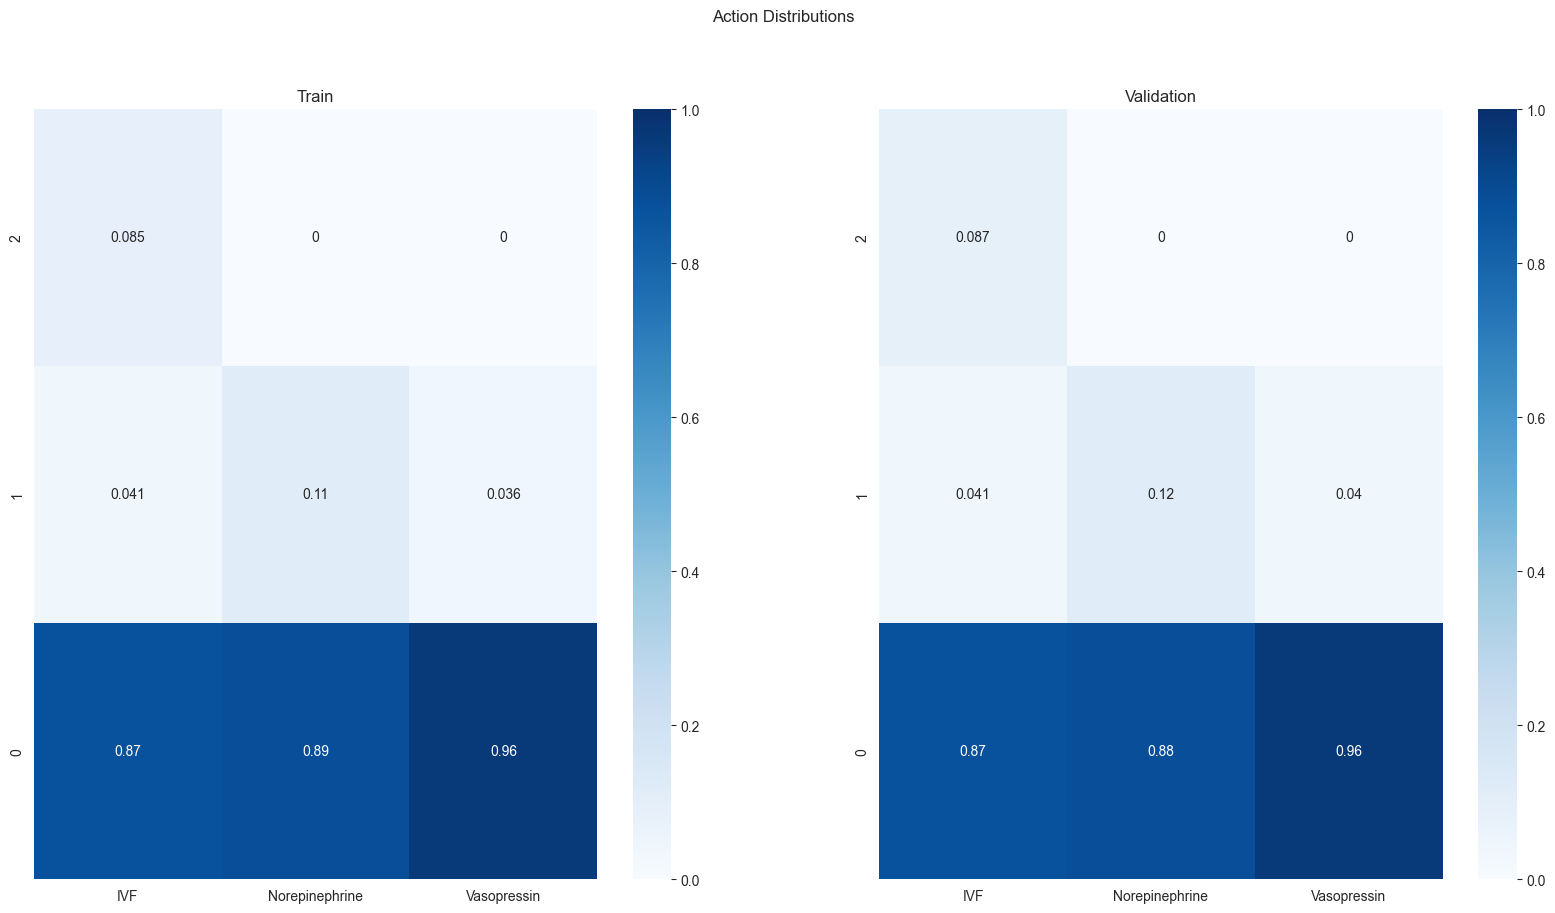

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Action Distributions')
sns.heatmap(train_sep_counts.T, vmin=0.0, vmax=1.0, cmap='Blues', annot=True, ax=axes[0])
axes[0].set_title('Train')
axes[0].invert_yaxis()
axes[0].set_xticklabels([action_space.Components.IVF.name, action_space.Components.Norepinephrine.name, action_space.Components.Vasopressin.name])
sns.heatmap(val_sep_counts.T, vmin=0.0, vmax=1.0, cmap='Blues', annot=True, ax=axes[1])
axes[1].set_title('Validation')
axes[1].invert_yaxis()
axes[1].set_xticklabels([action_space.Components.IVF.name, action_space.Components.Norepinephrine.name, action_space.Components.Vasopressin.name])
plt.show()

In [23]:
def plot_reward_distribution(num_splits: int):
    all_train_rewards = all_val_rewards = None
    for split in range(num_splits):
        (
            (train_states, train_actions, train_rewards, train_dones, train_next_states, train_missing_data),
            (val_states, val_actions, val_rewards, val_dones, val_next_states, val_missing_data),
            (_, _, _, _, _, _)
        ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'ope', 'discrete')
        train_rewards = train_rewards.sum(-1) # sum over timesteps
        val_rewards = val_rewards.sum(-1) # sum over timesteps
        if all_train_rewards is None:
            all_train_rewards = train_rewards
            all_val_rewards = val_rewards
        else:
            all_train_rewards = torch.cat([all_train_rewards, train_rewards], dim=0)
            all_val_rewards = torch.cat([all_val_rewards, val_rewards], dim=0)

    train_df = pd.DataFrame.from_dict({
        'train': all_train_rewards.tolist()
    })
    val_df = pd.DataFrame.from_dict({
        'val': all_val_rewards.tolist()
    })

    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    fig.suptitle('Reward Distributions')
    sns.histplot(train_df, bins=100, ax=axes[0])
    axes[0].set_title('Train')
    sns.histplot(val_df, bins=100, ax=axes[1])
    axes[1].set_title('Validation')

Data Split: 100%|██████████| 3/3 [00:26<00:00,  8.94s/ split]


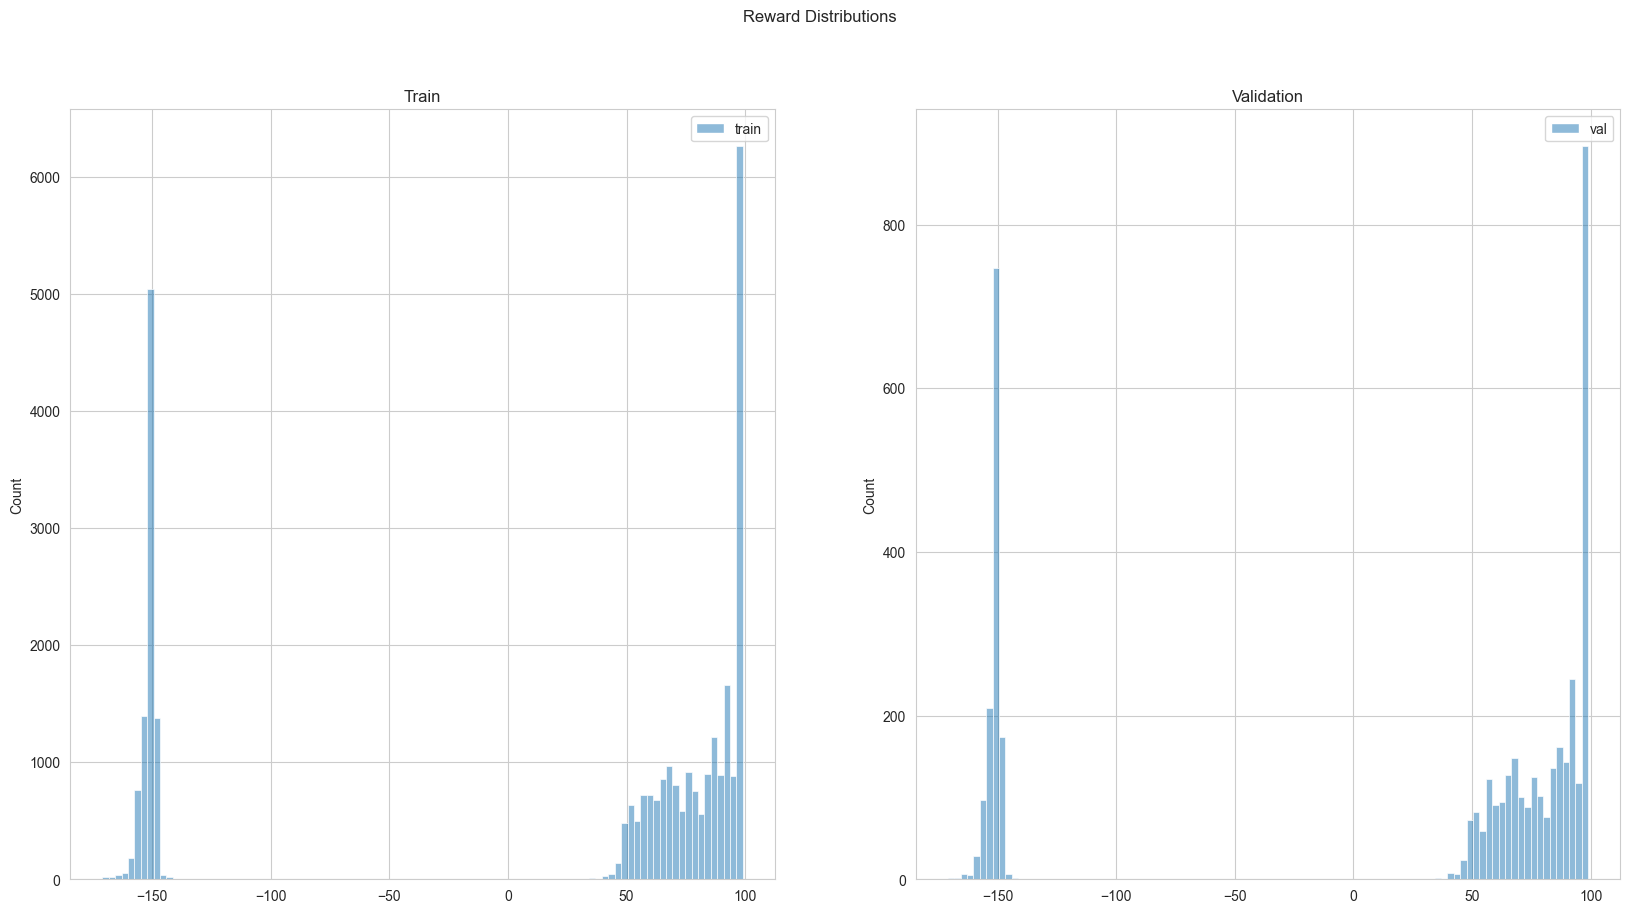

In [24]:
plot_reward_distribution(10)

In [25]:
def plot_last_action_timestep():
    """
    Only does it for the first split - aggregates validation and train
    :return:
    """
    all_train_rewards = all_val_rewards = None
    for split in range(0):
        (
            (train_states, train_actions, train_rewards, train_dones, train_next_states, train_missing_data),
            (val_states, val_actions, val_rewards, val_dones, val_next_states, val_missing_data),
            (_, _, _, _, _, _)
        ) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(split, 'ope', 'discrete')


In [34]:
(
    (train_states, train_actions, train_rewards, train_dones, train_next_states, train_missing_data),
    (val_states, val_actions, val_rewards, val_dones, val_next_states, val_missing_data),
    (test_states, test_actions, test_rewards, test_dones, test_next_states, test_missing_data)
) = trauma_icu_resuscitation_funcs.load_trauma_icu_resuscitation_data(0, 'ope', 'discrete')

Data Split: 100%|██████████| 3/3 [00:20<00:00,  6.73s/ split]


In [27]:
train_rewards.max()

tensor(100.)

In [29]:
split_0_df = pd.read_csv('<path_to_repo>/datasets/trauma_icu_resuscitation/stratified_splits/split_0.csv')
split_0_df.head()

,Unnamed: 0,traj,traj_length,resuscitated,split
0,0,2957,2,True,train
1,1,18451,19,True,train
2,2,23369,2,True,train
3,3,7727,38,True,train
4,4,20936,2,True,train


In [20]:
split_0_df[split_0_df.traj == 19690]

,Unnamed: 0,traj,traj_length,vent_free_days,split
1414,1414,19690,72,-25.0,train


In [30]:
split_0_df.shape[0]

4305

In [31]:
actions = torch.cat([train_actions, val_actions], dim=0)
last_ivf_actions = list()
last_vasopressin_actions = list()
last_nor_actions = list()
for i in range(actions.size(0)):
    for c_idx, l in zip([action_space.Components.IVF.value, action_space.Components.Vasopressin.value, action_space.Components.Norepinephrine.value],
                        [last_ivf_actions, last_vasopressin_actions, last_nor_actions]):
        nonzero = (actions[i, :, c_idx] > 0).nonzero()
        if nonzero.size(0) > 0:
            l.append(nonzero.max())
        else:
            l.append(0)

In [32]:
np.unique(last_ivf_actions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 64])

Text(0, 0.5, 'Frequency')

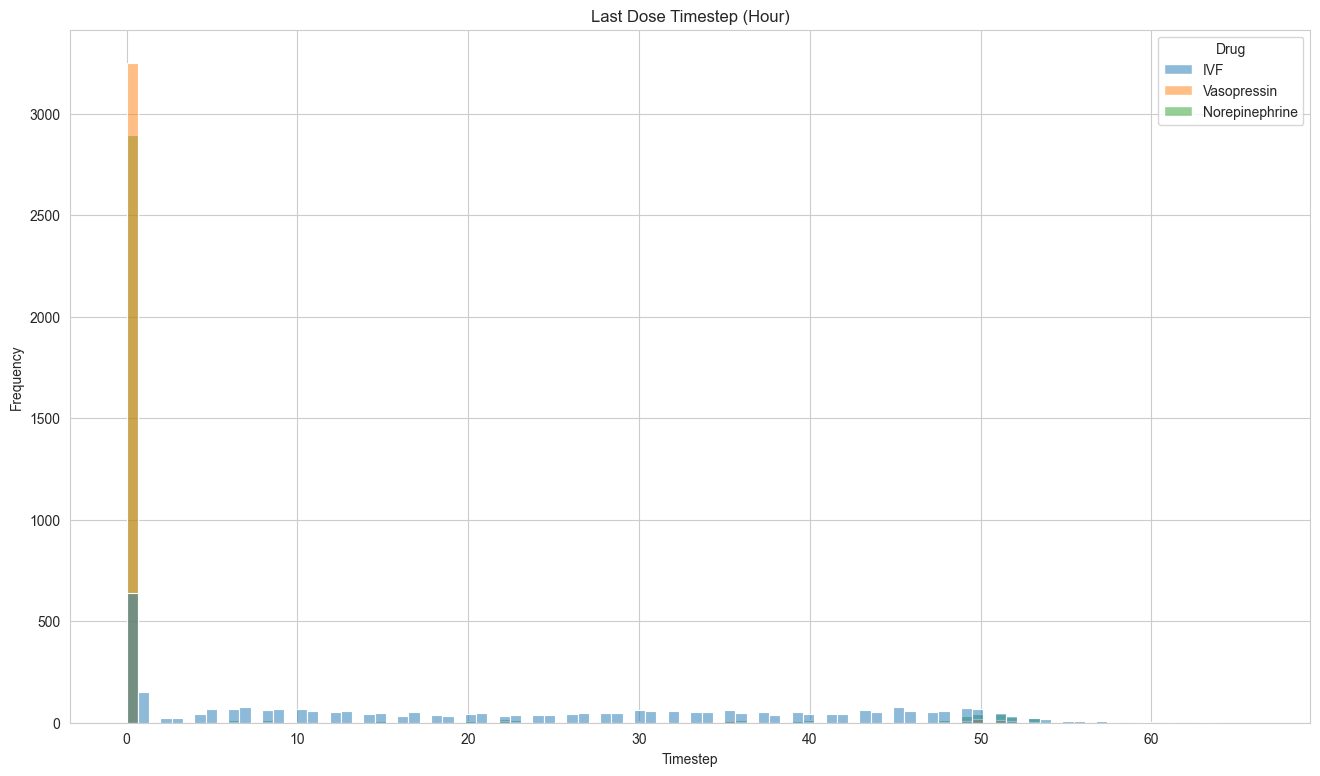

In [33]:
df_2 = pd.DataFrame.from_dict({
    'Values': np.concatenate([last_ivf_actions, last_vasopressin_actions, last_nor_actions]),
    'Drug': ['IVF'] * len(last_ivf_actions) + ['Vasopressin'] * len(last_vasopressin_actions) + ['Norepinephrine'] * len(last_nor_actions)
})
plt.figure(figsize=(16, 9))
sns.histplot(data=df_2, x='Values', hue='Drug', bins=100)
plt.title('Last Dose Timestep (Hour)')
plt.xlabel('Timestep')
plt.ylabel('Frequency')

In [35]:
actions = torch.cat([train_actions, val_actions, test_actions], dim=0)
last_actions = list()
for i in range(actions.size(0)):
    max_actions = actions[i, :, :].max(-1).values
    nonzero = (max_actions > 0).nonzero()
    if nonzero.size(0) > 0:
        last_actions.append(nonzero.max())
    else:
        last_actions.append(0)

In [37]:
last_actions = np.array(last_actions)
q25, q75 = np.percentile(last_actions, [25, 75])
iqr = q75 - q25
np.median(last_actions), iqr

(22.0, 36.0)